In [2]:
import yfinance as yf
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import os
import datetime
from datetime import timedelta, date
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from statistics import mean, stdev
import plotly.express as px
import webbrowser
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import numpy as np
from NotifyMe import Notifier
webbrowser.register('chrome', None, webbrowser.BackgroundBrowser('C:\\Program Files (x86)\\Google\\Chrome\\Application\\chrome.exe'))

In [3]:
#Set up notification system FOR MY USE ONLY
N = Notifier()

In [4]:
symbols = ['ACB', 'F', 'GE', 'DIS', 'AAL', 'GPRO', 'DAL', 'MSFT', 'CCL', 'AAPL', 'FIT', 'SNAP', 'PLUG', 'BAC', 'BA', 'NCLH', 'INO', 'UAL', 'UBER', 'CGC', 'TSLA', 'AMD', 'CRON', 'RCL', 'TWTR', 'GRPN', 'FB', 'SBUX', 'MRO', 'ZNGA', 'BABA', 'T', 'KO', 'APHA', 'USO', 'XOM', 'AMZN', 'MFA', 'JBLU', 'NIO', 'MRNA', 'LUV', 'GM', 'GILD', 'MGM', 'SAVE', 'NFLX', 'NRZ', 'SPCE', 'LK', 'VSLR', 'AMC', 'PENN', 'VOO', 'TLRY', 'HAL', 'NOK', 'NVDA', 'CPRX', 'LYFT', 'SQ', 'SPY', 'V', 'NKE', 'SIRI', 'UCO', 'WORK', 'CPE', 'BYND', 'KOS', 'ET', 'OXY', 'PFE', 'ZM', 'CRBP', 'SPHD', 'FCEL', 'VKTX', 'JPM', 'NTDOY', 'NYMT', 'BP', 'ATVI', 'CSCO', 'WFC', 'WMT', 'GOOGL', 'INTC', 'GLUU', 'AUY', 'VTI', 'ERI', 'TXMD', 'SNE', 'PTON', 'ROKU', 'JNJ', 'IVR', 'MU']

# Feature Engineering

Here I want to create a column that looks at the variance over time, and flags days where the change was greater than the variance. I'll ultimately use that as my target.
The idea behind this is if I see a movement that is statistically unlikely for a stock, then it's noteworthy and I should buy (either the stock or perhaps an option).

In [5]:
"""Look at week long spans"""
start_date = datetime.date(2020, 4, 1)
end_date =  datetime.date(2020, 9, 14)
df = pd.DataFrame()
for i in symbols:
    tckr = yf.Ticker(i)
    results = tckr.history(start=start_date, end = end_date)
    #results.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)
    results['Symbol'] =[i]* int(results.shape[0])
    results.reset_index(inplace = True)
    df = df.append(results, ignore_index=True)
    print(i, 'dataframe added to base.')
print('Complete')

ACB dataframe added to base.
F dataframe added to base.
GE dataframe added to base.
DIS dataframe added to base.
AAL dataframe added to base.
GPRO dataframe added to base.
DAL dataframe added to base.
MSFT dataframe added to base.
CCL dataframe added to base.
AAPL dataframe added to base.
FIT dataframe added to base.
SNAP dataframe added to base.
PLUG dataframe added to base.
BAC dataframe added to base.
BA dataframe added to base.
NCLH dataframe added to base.
INO dataframe added to base.
UAL dataframe added to base.
UBER dataframe added to base.
CGC dataframe added to base.
TSLA dataframe added to base.
AMD dataframe added to base.
CRON dataframe added to base.
RCL dataframe added to base.
TWTR dataframe added to base.
GRPN dataframe added to base.
FB dataframe added to base.
SBUX dataframe added to base.
MRO dataframe added to base.
ZNGA dataframe added to base.
BABA dataframe added to base.
T dataframe added to base.
KO dataframe added to base.
APHA dataframe added to base.
USO dat

In [21]:
sym_std = {}
for i in symbols:
    temp = df[df['Symbol'] == i]
    sym_std[i] = temp['Pct_Change'].std()*2
    print(i, temp['Pct_Change'].std()*2)

ACB 0.13343248353464854
F 0.05115597423479756
GE 0.059253917965292884
DIS 0.03718942028202498
AAL 0.10400683007897281
GPRO 0.06816306199607651
DAL 0.07406032953014807
MSFT 0.03351998340225763
CCL 0.10641774928457473
AAPL 0.03778670073491108
FIT 0.025908868651222924
SNAP 0.057640548936922165
PLUG 0.09099193983163768
BAC 0.04690748012232999
BA 0.07176158364526838
NCLH 0.11304004810806252
INO 0.1343073688571536
UAL 0.10342667993668338
UBER 0.05582104714766929
CGC 0.07465416183321856
TSLA 0.08537674449372341
AMD 0.06470470137706982
CRON 0.08060992919452377
RCL 0.10309771224670893
TWTR 0.04903767858051987
GRPN 0.12123428896263494
FB 0.041223384251526655
SBUX 0.031697281941371856
MRO 0.07936952266709968
ZNGA 0.045247858310586815
BABA 0.03168085418795402
T 0.027748531811688845
KO 0.0308186235923707
APHA 0.07478662473280896
USO 0.06000042563645456
XOM 0.048918699679086186
AMZN 0.03968507515897993
MFA 0.11344861053993194
JBLU 0.0780116843803193
NIO 0.11642918052245309
MRNA 0.09604356118607373
L

In [22]:
def daily_mean(x):
    values = [x['Open'], x['High'], x['Low'], x['Close']]
    return mean(values)
def daily_stddev(x):
    values = [x['Open'], x['High'], x['Low'], x['Close']]
    return stdev(values)
def daily_pct_change(x):
    return (x['Close']-x['Open'])/x['Open']
def notable_change(x):
    return 1 if abs(x['Pct_Change']) > sym_std[x['Symbol']] else 0
def prior_trend(x, num_of_days):
    _date =x['Date']
    _start = _date - timedelta(days=num_of_days)
    temp = df[df['Symbol'] == x['Symbol']]
    temp = temp[temp['Date'] <= _date]
    temp = temp[temp['Date']> _start]
    return temp['Pct_Change'].mean()

df['Mean'] = df.apply(lambda x: daily_mean(x), axis=1)
df['Std_Dev'] = df.apply(lambda x: daily_stddev(x), axis=1)
df['Pct_Change'] = df.apply(lambda x: daily_pct_change(x), axis=1)
df['Notable_Change'] = df.apply(lambda x: notable_change(x), axis=1)
df['Three_Day_Movement'] = df.apply(lambda x: prior_trend(x, 3), axis=1)
df['Five_Day_Movement'] = df.apply(lambda x: prior_trend(x, 5), axis=1)


In [23]:
df['Shifted_Notable_Change'] = df['Notable_Change'].shift(1)

for i in symbols:
    #remove all the earliest dates to account for the shift
    temp = df[df['Symbol'] ==i]
    index = temp[temp['Date']==temp['Date'].iloc[0]].index
    df.drop(index, inplace=True)

In [10]:
#convert df datetime to date
df['Date_Only'] = df['Date'].dt.date

In [11]:
#Label Encode Symbols 
encoder = LabelEncoder()
df['Enc_Symbol'] = encoder.fit_transform(df['Symbol'])

In [24]:
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Symbol,Mean,Std_Dev,Pct_Change,Date_Only,Enc_Symbol,Notable_Change,Three_Day_Movement,Five_Day_Movement,Shifted_Notable_Change
1,2020-04-02,9.96,11.02,9.61,10.00,2770000.0,0.0,0.0,ACB,10.1475,0.607474,0.004016,2020-04-02,2,0,-0.035611,-0.035611,0.0
2,2020-04-03,10.40,10.44,9.48,9.72,2549000.0,0.0,0.0,ACB,10.0100,0.483735,-0.065385,2020-04-03,2,0,-0.045536,-0.045536,0.0
3,2020-04-06,10.14,10.37,9.36,9.60,4244600.0,0.0,0.0,ACB,9.8675,0.467574,-0.053254,2020-04-06,2,0,-0.053254,-0.038208,0.0
4,2020-04-07,10.08,10.21,9.53,9.60,2423000.0,0.0,0.0,ACB,9.8550,0.340245,-0.047619,2020-04-07,2,0,-0.050437,-0.055419,0.0
5,2020-04-08,9.88,10.39,9.60,10.22,2888000.0,0.0,0.0,ACB,10.0225,0.352550,0.034413,2020-04-08,2,0,-0.022154,-0.022154,0.0


# Train Test Setup

In [25]:
columns = ['Volume', 'Dividends', 'Stock Splits', 'Pct_Change', 'Three_Day_Movement', 'Five_Day_Movement']
target_col = ['Shifted_Notable_Change']
X = df[columns]
y = df[target_col]

In [26]:
train_X, valid_X, train_y, valid_y = train_test_split(X,y, test_size=.3, train_size=.7, shuffle=False, stratify = None, random_state = 0) #double check stratify

In [27]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgb_params = {'max_depth':[i for i in range(3,11, 2)], 
              'n_estimators':[100, 300, 500, 1000, 5000, 10000], 
              'learning_rate':[.1], 
              'n_jobs':[4],
              }
xgb = XGBClassifier()
xgb_rand_search  = GridSearchCV(xgb, xgb_params, scoring='f1', cv=5, refit=True)
xgb_rand_search.fit(train_X, train_y)
print('Best Score:', xgb_rand_search.best_score_)
print('Best Parameters:', xgb_rand_search.best_params_)
print('Train Score:', xgb_rand_search.score(train_X, train_y))
print('Valid Score:', xgb_rand_search.score(valid_X, valid_y))
N.notify('Done Searching')

Best Score: 0.2010804850217073
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 1000, 'n_jobs': 4}
Train Score: 1.0
Valid Score: 0.17674418604651163


In [28]:
xgb_params = {'max_depth':5, 
              'n_estimators':100, 
              'learning_rate':.1, 
              'n_jobs':4,
              }
test_model = XGBClassifier(**xgb_params)
test_model.fit(X, y, verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

<AxesSubplot:>

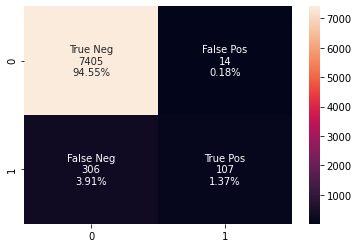

In [34]:
xgb_predictions = test_model.predict(train_X)

xgb_cf_matrix = confusion_matrix(train_y, xgb_predictions)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in xgb_cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in xgb_cf_matrix.flatten()/np.sum(xgb_cf_matrix)]
labels = [f'{_1}\n{_2}\n{_3}' for _1, _2, _3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(xgb_cf_matrix, annot=labels, fmt='')

# Simulate model with the past

The goal of this section is to run the model through a few months of use with imaginary money and see how it performs

In [85]:
class MyMoney:
    """
    This class serves to manage the portfolio/money aspect of the simulation.
    """
    def __init__(self, starting_funds):
        self.funds = starting_funds
        self.portfolio = {}
        self.chunk_pct = .2
    
    def add_to_portfolio(self, symbol, amount, date_added):
        if symbol not in self.portfolio.keys():
            self.portfolio[symbol] = [amount, date_added]
            self.funds = self.funds - amount
        else:
            self.portfolio[symbol] = [self.portfolio[symbol][0]+ amount, date_added]
            self.funds = self.funds - amount

    def sell_from_portfolio(self, symbol, pct_change):
        self.funds += (self.portfolio[symbol][0] + (self.portfolio[symbol][0]*pct_change))
        self.portfolio.pop(symbol)

    def total_portfolio(self, _date):
        total_amount = self.funds
        _keys = list(self.portfolio.keys())
        print('LOOK HERE',_keys)
        if len(_keys) == 0:
            return self.funds
        for i in _keys:
            date_bought = self.portfolio[i][1]
            date_sold = _date
            print(i)
            temp = df[df['Symbol']==i]
            print(temp)
            print(temp[temp['Date_Only']==date_bought]['Open'])
            buy_price = float(temp[temp['Date_Only']==date_bought]['Open'])
            sell_price = float(temp[temp['Date_Only']==date_sold]['Open'])
            pct_change = (sell_price-buy_price)/buy_price
            total_amount+= self.portfolio[i][0]+ (self.portfolio[i][0]*pct_change)
        return total_amount
    
    def get_amount(self, _date):
        want_to_spend = .2 * self.total_portfolio(_date)
        if want_to_spend< self.funds:
            return want_to_spend
        elif self.funds < want_to_spend and self.funds != 0:
            return self.funds
        else:
            return False

In [86]:
class StockSimulator:
    def __init__(self, start_date, symbols, model):
        self._date = start_date
        self.end_date = date(2020, 9, 1)
        self.symbols = symbols
        self.money = MyMoney(1000)
        self._LOG = pd.DataFrame()
        self.model = model
        self.input_symbols = ['Volume', 'Dividends', 'Stock Splits', 'Pct_Change', 'Three_Day_Movement', 'Five_Day_Movement']
    
    def collect_inputs(self): #SOMETHING WRONG HERE
        inputs = []
        for sym in self.symbols:
            temp = df[df['Symbol']==sym]
            temp = temp[temp['Date_Only']==self._date]
            temp = temp[self.input_symbols]
            inputs.append([sym,temp])
        return inputs

    def make_predictions(self, model_inputs):
        if model_inputs.empty:
            return False
        prediction = self.model.predict(model_inputs)
        if prediction != 0 and float(model_inputs['Pct_Change'])>0: 
            return True
        else:
            return False

    def transaction(self, symbol):
        amount = self.money.get_amount(self._date)
        if amount:
            print('Bought', symbol)
            self.money.add_to_portfolio(symbol, amount, self._date)

    def auto_sell(self):
        _keys = list(self.money.portfolio.keys())
        for i in _keys:
            if self.money.portfolio[i][1]+timedelta(days=2)<=self._date:
                if self._date in df['Date_Only'].unique():
                    date_bought = self.money.portfolio[i][1]
                    date_sold = self._date
                    temp = df[df['Symbol']==i]
                    buy_price = float(temp[temp['Date_Only']==date_bought]['Open'])
                    sell_price = float(temp[temp['Date_Only']==date_sold]['Open'])
                    change = (sell_price-buy_price)/buy_price
                    self.money.sell_from_portfolio(i, change)

    def RUN_SIM(self): #TODO this could use some serious cleanup for naming
        while self._date < self.end_date:
            if self._date in df['Date_Only'].unique():
                days_inputs = None
                days_inputs = self.collect_inputs()
                daily_predictions=[]
                for i in days_inputs:
                    daily_predictions.append([i[0], self.make_predictions(i[1])])
                for i in daily_predictions:
                    if i[1]:
                        self.transaction(i[0])
                self.auto_sell()
                print(self._date, self.money.total_portfolio(self._date))
            self._date  = self._date + timedelta(days=1)


In [87]:
sim = StockSimulator(date(2020, 4, 1), symbols, test_model)
print('Sim Starting...')
sim.RUN_SIM()

#NOTE TO SELF SOMETHING FUNKY WITH THE INPUTS ALL BEING THE SAME

RPN  32.9300  0.827889   -0.031110  2020-09-11   

      Enc_Symbol  Notable_Change  Three_Day_Movement  Five_Day_Movement  \
2851          35               0           -0.073359          -0.073359   
2852          35               0           -0.085491          -0.085491   
2853          35               0            0.037500          -0.058176   
2854          35               0           -0.003472          -0.038900   
2855          35               0            0.005261           0.005261   
...          ...             ...                 ...                ...   
2959          35               0            0.008153           0.002191   
2960          35               0           -0.006598           0.014564   
2961          35               0            0.028212           0.028212   
2962          35               0            0.011152           0.011152   
2963          35               0            0.002981           0.000586   

      Shifted_Notable_Change  
2851             

In [33]:
s = date(2020, 4, 1)
e = date(2020, 9, 1)
i = 0
while s != e:
    for i in symbols:
        if s in df['Date_Only'].unique():
            temp = df[df['Symbol']==i]
            day_inputs = temp[temp['Date_Only']==s]
            day_inputs = day_inputs[['Volume', 'Dividends', 'Stock Splits', 'Pct_Change', 'Three_Day_Movement', 'Five_Day_Movement']]
            print(test_model.predict(day_inputs))
    s+=timedelta(days=1)

[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[1.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[1.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[1.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[1.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
